# Tutorial 4: SpaCon for marmoset cortical gene expression and resting-state functional MRI data

This tutorial demonstrates how to use SpaCon to integrate marmoset gene expression and fMRI data. Both the transcriptomic and imaging datasets have already been mapped onto the marmoset cortical surface. The processed data for this tutorial can be downloaded from this [Google Drive link](https://drive.google.com/drive/folders/1lQQQVjXt8lvciuKq_Jkp4LGsR_EQXFAi?usp=sharing).


In [1]:
import spacon
from spacon.utils import create_spatial_graph_from_anndata, build_connection_graph, neighbor_sample, model_train, model_eval, clustering

from spacon.model import SpaCon
import datetime
import os
import scanpy as sc
import random
import torch
import numpy as np
import h5py

import warnings
warnings.filterwarnings("ignore")
mus = 'mouse_3'
if mus == 'mouse_1':  # coronal
    plot_x, plot_y = 'z', 'y'
    figsize = (5,5)
elif mus == 'mouse_3':   # sagittal
    plot_x, plot_y = 'x', 'y'
    figsize = (11,5)


def set_seed(seed: int):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

**Data preprocessing**

**Load spatial transcriptomics data**

If there are too many genes (for example, more than 5,000), we recommend first screening for highly variable genes using the following method:

```
n_top_genes = 3000
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=n_top_genes)
adata = adata[:, adata.var.highly_variable]
```

In [2]:
adata = sc.read_h5ad('/mnt/Data16Tc/home/haichao/code/SpaCon/ST_FC_cluster_marmoset/data/marmoset_cortical_5klabel_gene_exp.h5ad') 
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)  # add this to make the hightly_variable work

n_top_genes = 3000
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=n_top_genes)
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 5000 × 3000
    obs: 'x', 'y', 'z'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'spatial'

**Build spatial graph**

The `build_spatial_graph` function constructs a spatial graph using the three-dimensional spatial coordinates of the spatial transcriptome. The main parameters include:

- `adata`: Spatial transcriptomics data must include the three-dimensional coordinates for each spot (i.e., the slice number and the two-dimensional coordinates within that slice).
- `section_order`: A slice order list where the sequence represents the original arrangement of each slice within the brain. While the slices can be oriented differently, their relative order must be strictly maintained.
- `rad_cutoff`: Neighborhood radius, each spot will have edges added to all other spots within its neighborhood radius.
- `rad_cutoff_Zaxis`: Inter-slice neighborhood radius, each spot will have edges added to spots in adjacent slices that are within this radius.
- `sec_x`: The column name in `adata.obs` that stores the x-coordinate of each spot within its slice.
- `sec_y`: The column name in `adata.obs` that stores the y-coordinate of each spot within its slice.
- `key_section`: Column name in `adata.obs` that stores the slice number (where different numbers indicate different slices).


In [3]:
n_neighbors = 15
ST_graph_data, st_adj = create_spatial_graph_from_anndata(adata=adata,  n_neighbors=n_neighbors, spatial_key='spatial')
ST_graph_data

Data(x=[5000, 3000], edge_index=[2, 75000])

**Load connectivity data and build connection graph**

The `build_connection_graph` function uses connection information to construct a three-dimensional connection graph. The main parameters include:

- `nt_adj`: An n x n two-dimensional matrix, where n is the number of spots in the spatial transcriptomics data, representing the connection strength between spots.
- `threshold`: Filtering threshold, connection strengths below this value will be set to zero.

In [4]:
with h5py.File('/mnt/Data16Tc/home/haichao/code/SpaCon/ST_FC_cluster_marmoset/data/sub_all_lh_LR_bolddata_first512_5klabel_corr.mat', 'r') as f:
    print(list(f.keys()))
    marmoset_FC = f['mean_corr_data'][()] 
    print(marmoset_FC.shape)

['mean_corr_data']
(5000, 5000)


In [5]:
thr = 0.25
count = np.sum(marmoset_FC > thr)
total = marmoset_FC.size
ratio = count / total
ratio

np.float64(0.09871164)

In [6]:
NT_graph_data = build_connection_graph(adata, marmoset_FC, threshold=thr)
NT_graph_data

Data(x=[5000, 3000], edge_index=[2, 2467802])

**Neighbor-based subgraph sampling**

The `neighbor_sample` function performs subgraph sampling from the input spatial graph and connection graph. Its main parameters include:

- `batch_size`: The batch size for model training.
- `train_num_neighbors`: The number of neighbors to sample for each node in each iteration. This parameter is used by the data loader during the model training process.
- `eval_num_neighbors`: The number of neighbors to sample for each node in each iteration. This parameter is used by the data loader during the model evaluation process. If an entry is set to -1, all neighbors will be included.(default:`[-1]`)

The function returns three data loaders: `train_loader`, `evaluate_loader_con`, and `evaluate_loader_spa`. The `train_loader` is used during the **model training process**. Meanwhile, `evaluate_loader_con` and `evaluate_loader_spa` are used for **model evaluation** on the **connection graph** and **spatial graph**, respectively.

In [7]:
train_loader, evaluate_loader_con, evaluate_loader_spa = neighbor_sample(NT_graph_data, ST_graph_data, batch_size=64, train_num_neighbors=[20, 10, 10], num_workers=4)

**Model training**

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# hyper-parameters
num_epoch = 20
lr = 0.0001
weight_decay = 1e-4
hidden_dims = [adata.X.shape[1]] + [512, 128, 32]    
# model
# fusion_method indicates the feature fusion method of the middle layer, you can choose 'add' or 'concat'
model = SpaCon(hidden_dims=hidden_dims, fusion_method='concat').to(device)
# if model_save_path=None, the model will not be saved
results_save_path = f"./results_marmoset/{str(datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S'))}/"
os.makedirs(results_save_path, exist_ok=True)

model = model_train(num_epoch, lr, weight_decay, model, train_loader, st_adj, model_save_path=results_save_path, device=device)

epoch:1|20


100%|██████████| 79/79 [00:04<00:00, 18.40it/s]


epoch:2|20


100%|██████████| 79/79 [00:03<00:00, 20.60it/s]


epoch:3|20


100%|██████████| 79/79 [00:03<00:00, 20.07it/s]


epoch:4|20


100%|██████████| 79/79 [00:04<00:00, 19.47it/s]


epoch:5|20


100%|██████████| 79/79 [00:03<00:00, 19.94it/s]


epoch:6|20


100%|██████████| 79/79 [00:03<00:00, 20.03it/s]


epoch:7|20


100%|██████████| 79/79 [00:04<00:00, 19.54it/s]


epoch:8|20


100%|██████████| 79/79 [00:03<00:00, 20.30it/s]


epoch:9|20


100%|██████████| 79/79 [00:03<00:00, 20.17it/s]


epoch:10|20


100%|██████████| 79/79 [00:03<00:00, 19.80it/s]


epoch:11|20


100%|██████████| 79/79 [00:03<00:00, 19.83it/s]


epoch:12|20


100%|██████████| 79/79 [00:03<00:00, 20.12it/s]


epoch:13|20


100%|██████████| 79/79 [00:03<00:00, 20.34it/s]


epoch:14|20


100%|██████████| 79/79 [00:03<00:00, 19.78it/s]


epoch:15|20


100%|██████████| 79/79 [00:03<00:00, 20.34it/s]


epoch:16|20


100%|██████████| 79/79 [00:03<00:00, 20.11it/s]


epoch:17|20


100%|██████████| 79/79 [00:04<00:00, 19.68it/s]


epoch:18|20


100%|██████████| 79/79 [00:03<00:00, 19.94it/s]


epoch:19|20


100%|██████████| 79/79 [00:03<00:00, 20.03it/s]


epoch:20|20


100%|██████████| 79/79 [00:03<00:00, 20.12it/s]




Training completed! The model parameters have been saved to ./results_marmoset/2025_07_24_15_29_14/model_params.pth


**Model evaluation**

The features obtained after model dimensionality reduction, named `feature_spa` and `feature_con`, are stored in the returned `adata.obsm`. These features can be used for subsequent cluster analysis.

In [9]:
adata = model_eval(model, adata, NT_graph_data, ST_graph_data, evaluate_loader_con, evaluate_loader_spa, st_adj, layer_eval=True, device=device)

Evaluating: 100%|██████████| 15000/15000 [00:03<00:00, 4768.18it/s]


The results have been saved in adata.obsm
AnnData object with n_obs × n_vars = 5000 × 3000
    obs: 'x', 'y', 'z'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'spatial', 'feature_spa', 'feature_con'


**Clustering**

The `clustering` function performs clustering using the louvain algorithm, with the following key parameters:

* `adata`: The AnnData object obtained previously, which contains the clustering features (`feature_spa`, `feature_con`).
* `alpha`: This parameter adjusts the contribution of local spatial information versus global connection information in the clustering results.
    * When `alpha = 1`, the clustering will incorporate more global information.
    * When `alpha = 0`, the clustering will focus more on local information.
    You can set different `alpha` values based on your downstream tasks.
* `adata_save_path`: The path where the results will be saved.
* `cluster_resolution`: The clustering resolution used during the louvain clustering process.

The clustering results have been saved in ./results_marmoset/2025_07_24_15_29_14/feature_add_weight1/Clusters_res0.4/
AnnData object with n_obs × n_vars = 5000 × 3000
    obs: 'x', 'y', 'z', 'clusters'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'neighbors', 'umap', 'clusters', 'clusters_colors'
    obsm: 'spatial', 'feature_spa', 'feature_con', 'feature_add', 'X_umap'
    obsp: 'distances', 'connectivities'


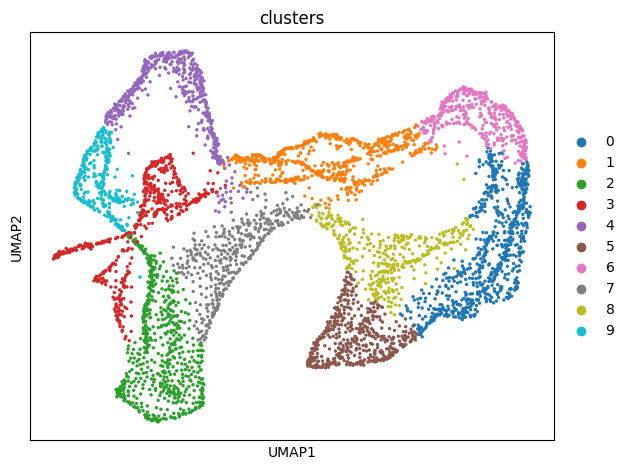

In [20]:
adata, path = clustering(adata, alpha=1, adata_save_path=results_save_path, cluster_resolution=0.4)

In [21]:
import nibabel as nib

# --------------------- 1. Read parcel label file ---------------------
shape_gii = nib.load('/mnt/Data16Tc/home/haichao/code/SpaCon/ST_FC_cluster_marmoset/surface/surfFS.lh.MBM_cortex_vPaxinos_5klabel.shape.gii')
parcel_labels = shape_gii.darrays[0].data  # Shape: (n_vertices,)

# --------------------- 2. Read cluster labels and convert to integer ---------------------
# Extract cluster label column and convert to integer
cluster_labels_str = adata.obs['clusters'].values  # String format
cluster_labels = cluster_labels_str.astype(int)  # Convert to integer array
cluster_labels = cluster_labels+1
# cluster_labels[cluster_labels != 4] = 0

# --------------------- 3. Map parcel cluster labels to vertices ---------------------
# Initialize vertex cluster label array (background label 0 remains 0)
vertex_clusters = np.zeros_like(parcel_labels, dtype=int)

for parcel_id in range(1, 5001):  # Iterate through parcels 1-5000
    # Find vertex indices belonging to the current parcel
    mask = (parcel_labels == parcel_id)
    # Assign the current parcel's cluster label to these vertices
    vertex_clusters[mask] = cluster_labels[parcel_id - 1]  # DataFrame row index starts from 0

# --------------------- 4. Save as .func.gii file ---------------------
metadata = {
    'AnatomicalStructurePrimary': 'CortexLeft',  # Must be consistent with the surface file
    'GeometricType': 'Functional',  # Set to 'Functional' (original surface file was 'Unknown')
    'Name': 'ClusterLabels',
    'UniqueID': 'CustomID',  # Custom unique ID
}
# Create GIfTI data array
data_array = nib.gifti.GiftiDataArray(
    data=vertex_clusters,
    intent='NIFTI_INTENT_NONE',  # Or 'NIFTI_INTENT_LABEL' (depending on data type)
    datatype='NIFTI_TYPE_INT32',
    meta=nib.gifti.GiftiMetaData(metadata)  # Add metadata
)

# Create GIfTI image object and save
func_gii = nib.gifti.GiftiImage(darrays=[data_array])
nib.save(func_gii, path + 'cluster_labels.func.gii')